In [1]:
from pathlib import Path

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
from PubTabNetDataset import PubTabNet
from TesseractUtils import im_to_data, scale

In [4]:
import cv2
COLORS = {
    'black':(0,0,0),
    'red':(150,0,0),
    'green':(0,150,0),
    'blue':(0,0,150)
}

def draw(im, bbox, color='black'):
    im = np.array(im)  # in case it is in PIL format
    x,y,w,h = bbox
    W,H,_ = im.shape
    
    if isinstance(color, str):
        color = COLORS[color]
    
    pt1 = (x, y)
    pt2 = (x+w, y+h)
    return cv2.rectangle(im, pt1=pt1, pt2=pt2,
        color=color, thickness=1
    )

In [5]:
data_dir = Path(r"C:\Users\stans\Documents\Projects\Datasets\pubtabnet.tar\pubtabnet\pubtabnet")
train_dir = data_dir / "train"
target_path = data_dir / "PubTabNet_2.0.0.jsonl"
TrainDataset = PubTabNet(train_dir)

## KDTree (waste of time)

In [ ]:
from scipy.spatial import KDTree

In [ ]:
from copy import deepcopy

In [ ]:
arr = np.array(TrainDataset[0][0].getchannel(0))<100

In [ ]:
y, x = arr.shape
X = []
for i in range(y):
    for j in range(x):
        if arr[i,j]:
            X.append([i,j])
X = np.array(X)

In [ ]:
def traverse(arr, node, bounds=None):
    if bounds is None:
        dims = len(arr.shape)
        bounds = []
        for d in range(dims):
            bounds.append([0,None])
    
    if not isinstance(node, KDTree.leafnode):
        slicer = []
        for d in range(len(arr.shape)):
            if d == node.split_dim:
                slicer.append(int(node.split))
            else:
                slicer.append(slice(bounds[d][0], bounds[d][1]))
        # print(node.split_dim, node.split, slicer, bounds)
        arr[tuple(slicer)] = 1
        
        l_bounds = deepcopy(bounds)
        r_bounds = deepcopy(bounds)
        
        l_bounds[node.split_dim][1] = int(node.split)
        
        r_bounds[node.split_dim][0] = int(node.split)
        
        traverse(arr, node.less, l_bounds)
        traverse(arr, node.greater, r_bounds)

In [ ]:
tree = KDTree(X,leafsize=200, copy_data=True,balanced_tree=False,compact_nodes=False)

In [ ]:
# arr_cp = np.zeros((25,25))
arr_cp = ocr_mask.copy()
traverse(arr_cp, tree.tree)

In [ ]:
plt.imshow(arr_cp)

In [ ]:
root.less.less

In [ ]:
np.ones((4,4))[tuple([slice(0,2),slice(0,2)])]

In [ ]:
ocr_df = im_to_data(im, 3)

In [ ]:
ocr_mask = np.zeros(arr.shape)
for bbox in ocr_df[['left', 'top', 'width', 'height']].values:
    x,y,w,h = bbox
    ocr_mask[y:y+h, x:x+w]=1

In [ ]:
y, x = ocr_mask.shape
X = []
for i in range(y):
    for j in range(x):
        if ocr_mask[i,j]:
            X.append([i,j])
X = np.array(X)

In [ ]:
X

## Custom SVM

In [6]:
def partition(boxes, axis_idx, length_idx, margin=0):
    """
    partitions a list of bounding boxes (in x,y,w,h format)
    into a list of lists, where each element of the inner
    lists is at least `margin` units away from the bboxes
    from every other group.
    """
    boxes.sort(key=lambda x: x[axis_idx]+x[length_idx]) # sort by x_max
    boxes.sort(key=lambda x: x[axis_idx]) # sort by x_min
    
    groups = []
    
    last_x = boxes[0][axis_idx] + boxes[0][length_idx]
    last_i = 0
    
    for i,b in enumerate(boxes):
        if b[axis_idx] > last_x+margin:
            groups.append(boxes[last_i:i])
            last_x = b[axis_idx]+b[length_idx]
            last_i = i
            
        elif b[axis_idx]+b[length_idx]>last_x:
            last_x = b[axis_idx]+b[length_idx]
    
    groups.append(boxes[last_i:])
    return groups

def fit_contents(boxes):
    """
    returns the smallest box which encompases all of the boxes
    """
    x = min([b[0] for b in boxes])
    y = min([b[1] for b in boxes])
    w = max([b[0]+b[2] for b in boxes]) - x
    h = max([b[1]+b[3] for b in boxes]) - y
    return x,y,w,h

In [7]:
im, target = TrainDataset[0]
ocr_df = im_to_data(im, 4)

In [8]:
boxes = list(ocr_df[['left', 'top', 'width', 'height']].values)

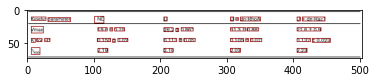

In [9]:
im_cp = np.array(im)
for cell in boxes:
    im_cp = draw(im_cp, cell, "red")
plt.imshow(im_cp)

In [10]:
margin_y = 2
margin_x = 5
rows = []
for row in partition(boxes, 1, 3, margin_y):
    groups = partition(row,0,2, margin_x)
    r = []
    for g in groups:
        r.append(fit_contents(g))
    rows.append(r)

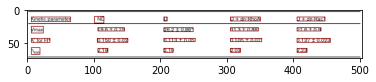

In [11]:
im_cp = np.array(im)
for r in rows:
    for cell in r:
        im_cp = draw(im_cp, cell, "red")
plt.imshow(im_cp)

In [12]:
import pandas as pd

def contains(coords1, coords2):
    xa, ya, wa, ha = coords1
    xb, yb, wb, hb = coords2
    px = xb + wb/2
    py = yb + hb/2
    return xa < px and (xa + wa) > px and ya < py and (ya + ha) > py




def group_ocr_bboxes(
    im,
    scaling_factor=1,
    margin_x_factor = 2,  # percentage of average character width
    margin_y_factor = 0.5,  # percentage of average character height
):
    ocr_df = im_to_data(im, scaling_factor)
    boxes = list(ocr_df[['left', 'top', 'width', 'height']].values)
    
    
    heights = [b[2] for b in boxes]
    avg_height = sum(heights)/len(heights)
    
    normalized_widths = [b[3]/len(ocr_df["text"][i]) for i, b in enumerate(boxes)]
    avg_width = sum(normalized_widths)/len(normalized_widths)
    
    margin_y = avg_height * margin_y_factor
    margin_x = avg_width * margin_x_factor
    
    rows = []
    for row in partition(boxes, 1, 3, margin_y):
        groups = partition(row,0,2, margin_x)
        r = []
        for g in groups:
            r.append(fit_contents(g))
        rows.append(r)
    
    new_df = []
    texts = ocr_df["text"]
    boxes = list(ocr_df[['left', 'top', 'width', 'height']].values)
    
    n_cols = 0
    for i, row in enumerate(rows):
        if len(row) > n_cols:
            n_cols = len(row)
        for cell in row:
            x,y,w,h = cell
            text = " ".join([texts[i] for i,b in enumerate(boxes) if contains(cell, b)])
            new_df.append(
                {
                    "left": x,
                    "top": y,
                    "width": w,
                    "height": h,
                    "text": text,
                    "row": i,
                }
            )
    
    # Assign column positions
    g_model = GMM(n_components=n_cols)
    new_df = pd.DataFrame(new_df)
    boxes = list(new_df[['left', 'top', 'width', 'height']].values)
    X = [[x[0], x[0]+x[2]] for x in boxes]
    y = g_model.fit_predict(X)
    
    # sort categories by x_pos
    cats = list(
        zip(*sorted(zip(g_model.means_.min(axis=1), np.arange(n_cols))))
    )[1]
    
    # assign column positions to new df
    column = []
    for c in y:
        column.append(cats.index(c))
    
    new_df["col"] = column
    
    
    return new_df

def im_to_table(im):
    df = im_to_cells(im, 3, 4, 0.03)
    rows = max(df["row"])
    cols = max(df["col"])
    data = [["" for i in range(cols+1)] for j in range(rows+1)]
    for cell in df.to_dict("records"):
        data[cell["row"]][cell["col"]] = cell["text"]
    return pd.DataFrame(data)

In [24]:
im, target = TrainDataset[10]
# im = scale(im,2)
df = im_to_data(im,3)

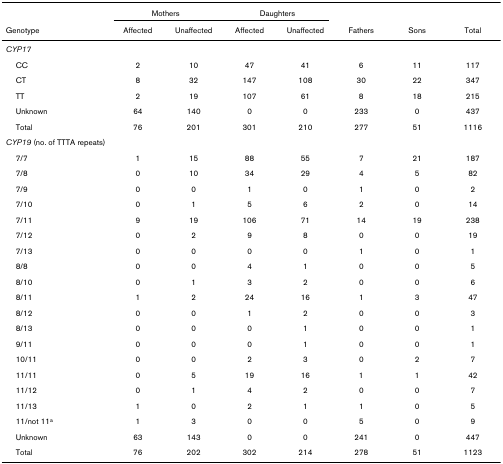

In [25]:
im

In [26]:
df

,index,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
0,4,5,1,1,1,1,1,147,8,32,10,89.0,Mathers
1,5,5,1,1,1,1,2,260,10,35,8,96.0,Daughters
2,7,5,1,1,1,2,1,2,25,37,11,94.0,Genotype
3,8,5,1,1,1,2,2,123,25,29,11,93.0,Affected
4,9,5,1,1,1,2,3,171,25,40,11,95.0,Unaffected
...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,240,5,1,3,1,1,4,240,448,15,10,93.0,302
205,241,5,1,3,1,1,5,298,449,13,6,95.0,214
206,242,5,1,3,1,1,6,354,449,13,6,91.0,278
207,243,5,1,3,1,1,7,413,449,7,6,67.0,61


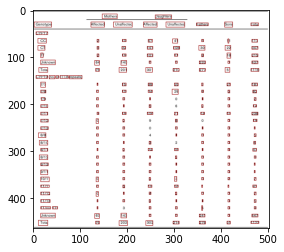

In [27]:
boxes = list(df[['left', 'top', 'width', 'height']].values)
im_cp = np.array(im)
for cell in boxes:
    im_cp = draw(im_cp, cell, "red")
plt.imshow(im_cp)

In [103]:
from copy import deepcopy
def partition_2(boxes, axis=1, margin=None, on_lethal=False, coords=None):
    """
    partitions a list of bounding boxes (in x,y,w,h format)
    into a list of lists, where each element of the inner
    lists is at least `margin` units away from the bboxes
    from every other group.
    """
    if coords is None:
        coords = [0,0]
        
    if margin is None:
        margin = [0,0]
    
    if len(boxes) <= 1:
        return [(boxes, coords)]
    
    boxes.sort(key=lambda x: x[axis]+x[axis+2])  # sort by x_max
    boxes.sort(key=lambda x: x[axis])  # sort by x_min
    
    groups = []
    
    last_x = boxes[0][axis] + boxes[0][axis+2]
    last_i = 0
    
    for i,b in enumerate(boxes):
        if b[axis] > last_x + margin[axis]:
            g_coords = deepcopy(coords)
            g_coords[axis] = g_coords[axis]+1
            less = " ".join([x[4] for x in boxes[:i]])
            greater = " ".join([x[4] for x in boxes[i:]])
            return (
                partition_2(boxes[:i], -(axis-1), margin, coords=coords)
                + partition_2(boxes[i:], -(axis-1), margin, coords=g_coords)
            )
        elif b[axis]+b[axis+2]>last_x:
            last_x = b[axis]+b[axis+2]
    
    if on_lethal:
        return [(boxes, coords)]
    return partition_2(boxes, -(axis-1), margin, coords=coords, on_lethal=True)
    
    

In [104]:
im, _ = TrainDataset[0]
df = im_to_data(im, 3)

In [116]:
from PIL import Image

In [117]:
im = Image.open("Capture.PNG")

In [130]:
df = im_to_data(im,2)

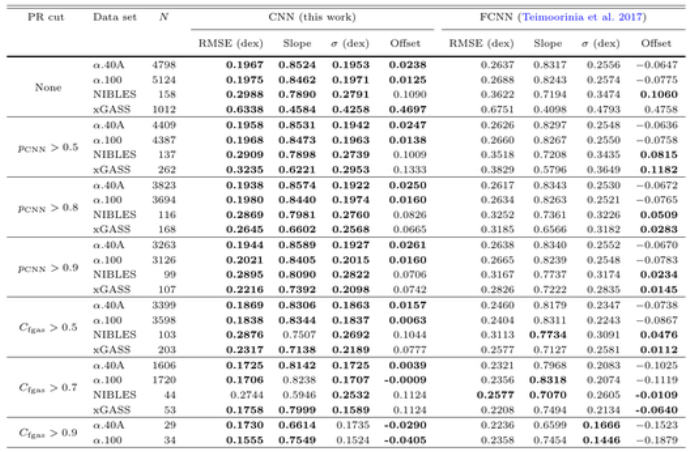

In [131]:
im

In [132]:
boxes = list(df[['left', 'top', 'width', 'height',"text"]].values)

In [133]:
cells = partition_2(boxes, margin=(5,5))

In [134]:
rows = max([x[1][1] for x in cells])+1
cols = max([x[1][0] for x in cells])+1
data = [["" for i in range(cols)] for j in range(rows)]
for tokens, coords in cells:
    j,i = coords
    data[i][j] = " ".join([x[4] for x in tokens])
pd.DataFrame(data)

,0,1,2,3,4,5,6,7,8,9,10
0,PR cut,Data set,N,CNN (this work),FCNN (Teimoorinia et,al. 2017),,,,,
1,aes,RMSE (dex),Slope,@,(dex),Offset’,+=,RMSE (dex),Slope,@ (dex),Offset
2,pens,oO a4d0A,0.1967,0.8524,0.1953,0.0238 0.0125,0.2637 0.2688,0.8317 0.8243,0.2556,,
3,OS >,NIBLES,0.2988,0.7890,0.2791,0.1090,0.3622,0.7194,0.3474,,
4,Crm,xGASS,0.6338,0.4584,0.4697,0.6751,0.4098,0.4793,,,
5,Cane lene,4409,0.1958,0.8531,0.0247,0.2626,0.8207,0.2548,,,
6,Can ™,100,0.1968,0.8473,0.0138,0.2660,0.8267,0.2550,,,
7,,opies,0.2909,0.7898,0.1009,0.3518,0.7208,0.3435,,,
8,,xGASS,0.3235,0.6221,0.1333,0.3829 0.2617 0.2634,0.5796,0.3649,,,
9,,116 168 xGASs adda 3263 100-3126,0.1938,0.8574,0.0250 0.0160,0.3252 O.3185 0.2638 0.2665,ORM,0.2530,,,


In [47]:
boxes = [
    [0,0,2,2],
    [0,3,4,2],
    # [0,3,2,2],
    [3,0,2,2],
]

In [48]:
partition_2(boxes)

[[([[0, 0, 2, 2]], [0, 0]), ([[3, 0, 2, 2]], [1, 0])],
 ([[0, 3, 4, 2]], [0, 1])]